In [127]:
import os
import numpy as np
import numpy.random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, norm
from scipy.optimize import curve_fit

In [2]:
# Probability for BTW and Oslo Models
BTW_probability = 1
Oslo_probability = 0.5
# Lengths to be investigated
L = [4, 8, 16, 32, 64, 128, 256, 512] 

In [3]:
# Settings for matplotlib
params = { 'axes.labelsize': 14,
           'axes.titlesize': 14,
           'xtick.labelsize': 12,
           'ytick.labelsize': 12,
           'figure.figsize': [9, 4],
           'figure.dpi': 150,
           'figure.titlesize': 14,
           'grid.linewidth':0.5, 
           'legend.fontsize': 10}
plt.rcParams.update(params)

In [4]:
class Pile:
    def __init__(self, length, probability=0.5):
        self.probability = probability
        self.length = length
        self.lattice = np.zeros(length)
        self.gradient = np.zeros(length, dtype=np.int)
        self.threshold = np.round(np.random.random(length)\
                                  + 1.5\
                                  - self.probability).astype(np.int)
        self.grains_dropped = 0
        self.grains_left = 0
        self.height = 0
        self.avalanche_size = 0
        self.cross_over_state = False
    
    def get_grains_dropped(self):
        return self.grains_dropped
    
    def get_grains_left(self):
        return self.grains_left
    
    def get_size(self):
        return self.grains_dropped - self.grains_left
    
    def get_height(self):
        return self.height
    
    def get_avalanche_size(self):
        return self.avalanche_size
    
    def get_gradient(self):
        return self.gradient
    
    def get_threshold(self):
        return self.threshold
    
    def drive(self, site=0):
        '''Adds 1 grain'''
        self.avalanche_size = 0
        self.gradient[site] += 1
        self.height += 1
        self.grains_dropped += 1
        
    def relax(self, site):
        '''Relaxes site gradients according to Oslo model rules'''
        if site == 0:
            self.height -= 1
            self.gradient[site] -= 2
            self.gradient[site + 1] += 1
        elif site == self.length - 1:
            self.gradient[site] -= 1
            self.gradient[site-1] += 1
            self.cross_over_state = True
            self.grains_left += 1
        else:
            self.gradient[site] -= 2
            self.gradient[site-1] += 1
            self.gradient[site+1] += 1
        self.update_threshold(site)    
    
    def update_threshold(self, site):
        '''Updates threshold to 1 with probability p and 2 otherwise'''
        self.threshold[site] = round(1.5\
                                       - self.probability\
                                       + np.random.random())
    
    def find_unstable_sites(self):
        return np.where(np.greater(self.gradient, self.threshold))[0]
    
    def drop_grain(self, site=0):
        '''Starts 1 drive process and relaxes until stable'''
        self.drive(site)
        while True:
            unstable_sites = self.find_unstable_sites()
            if unstable_sites.size < 1:
                break
            else:
                for i in unstable_sites:
                    self.avalanche_size += 1
                    self.relax(i)


## Task 1: Testing the Program

### Test: $p=1$, BTW Model

Let $p=1$, and check the following:
- All threshold values are 1
- All gradients are 1 in the steady state.

In [4]:
BTW_Model = Pile(8, BTW_probability)
print('Threshold: {}'.format(BTW_Model.get_threshold()))

Threshold: [1 1 1 1 1 1 1 1]


In [5]:
for i in range(100): #100 enough to reach steady state
    BTW_Model.drop_grain()
print('''
    Thresholds: {}
    Gradients: {}
    Height: {}'''
    .format(BTW_Model.get_threshold(), 
            BTW_Model.get_gradient(), 
            BTW_Model.get_height()))


    Thresholds: [1 1 1 1 1 1 1 1]
    Gradients: [1 1 1 1 1 1 1 1]
    Height: 8


Threshold, gradient and height as expected for BTW model.

### Test: $p=0$

Let $p=0$, and check the following:
- All threshold values are 0
- All gradients are 2 in the steady state.

Essentially double the values in BTW Model

In [6]:
Zero_Model = Pile(8, 0)
for i in range(100):
    Zero_Model.drop_grain()
print('''
    Thresholds: {}
    Gradients: {}
    Height: {}'''
    .format(Zero_Model.get_threshold(), 
            Zero_Model.get_gradient(), 
            Zero_Model.get_height()))


    Thresholds: [2 2 2 2 2 2 2 2]
    Gradients: [2 2 2 2 2 2 2 2]
    Height: 16


Threshold, gradient and height as expected.

### Test: Average Height at Steady State

In [7]:
Oslo_Model_16 = Pile(16, Oslo_probability)
Oslo_Model_32 = Pile(32, Oslo_probability)
heights_16 = []
heights_32 = []
for i in range(50000):
    Oslo_Model_16.drop_grain()
    Oslo_Model_32.drop_grain()
    heights_16.append(Oslo_Model_16.get_height())
    heights_32.append(Oslo_Model_32.get_height())
print('''
    Height for L=16: {}
    Height for L=32: {}'''
    .format(np.mean(heights_16), np.mean(heights_32)))

KeyboardInterrupt: 

In the steady state, the Oslo models results in $\langle h_{16} \rangle = 26.5$ and $\langle h_{32} \rangle = 53.9$ as expected.

## Creating Dataset

We aim to collect data until the steady state has been reached. We use cross-over time as an estimate for the time required to reach steady state. We only consider cross-over time for the largest pile L=512 since time for all other pile sizes will be smaller.

In [11]:
def measure_cross_over_time(n):
    Oslo_Model = Pile(n)
    while not Oslo_Model.cross_over_state:
        Oslo_Model.drop_grain()
    return Oslo_Model.get_grains_dropped()

In [13]:
measure_cross_over_time(512)

223626

We will simulate 5e5 grains, roughly double the cross-over time measured above. The data will be generated and saved in a npy file. Simulations will be done 5 times to smoothen data.

In [58]:
n = 5e5
for m in range(5):
    piles = [Pile(l) for l in L]
    data = []
    for i in range(int(n)):
        for pile in piles:
            pile.drop_grain()
        data.append([[pile.get_height(), pile.get_avalanche_size()] for pile in piles])
    data_np = np.array(data)
    np.save('data{}.npy'.format(str(m)), data_np)

We will load the data into a Pandas DataFrame for convenient manipulation. We average over all simulations for each L.

In [6]:
n = 5e5
data = np.load('data/data0.npy').reshape((int(n), 2*len(L)))
columns = [i for pair in [[str(l)+'h', str(l)+'s'] for l in L] for i in pair]
df = pd.DataFrame(data, columns = columns)
df.head()

,4h,4s,8h,8s,16h,16s,32h,32s,64h,64s,128h,128s,256h,256s,512h,512s
0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
1,2,0,2,0,2,0,2,0,2,0,2,0,2,0,2,0
2,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1
3,3,0,2,1,2,1,3,0,2,2,3,0,2,2,2,1
4,3,1,3,0,3,0,3,1,2,1,3,1,2,1,3,0


In [7]:
data_h = []
data_s = []
data = np.load('data/data0.npy')
df_h = pd.DataFrame(data[:,:,0], columns=L)
df_s = pd.DataFrame(data[:,:,1], columns=L)
df_h['t'] = df_h.index + 1
df_s['t'] = df_s.index + 1
print(df_h.head(), '\n')
print(df_s.head())

   4  8  16  32  64  128  256  512  t
0  1  1   1   1   1    1    1    1  1
1  2  2   2   2   2    2    2    2  2
2  2  2   2   2   2    2    2    2  3
3  3  2   2   3   2    3    2    2  4
4  3  3   3   3   2    3    2    3  5 

   4  8  16  32  64  128  256  512  t
0  0  0   0   0   0    0    0    0  1
1  0  0   0   0   0    0    0    0  2
2  1  1   1   1   1    1    1    1  3
3  0  1   1   0   2    0    2    1  4
4  1  0   0   1   1    1    1    0  5


## Task 2: Height of Pile

### Task 2a: Pile Height as a Function of Time

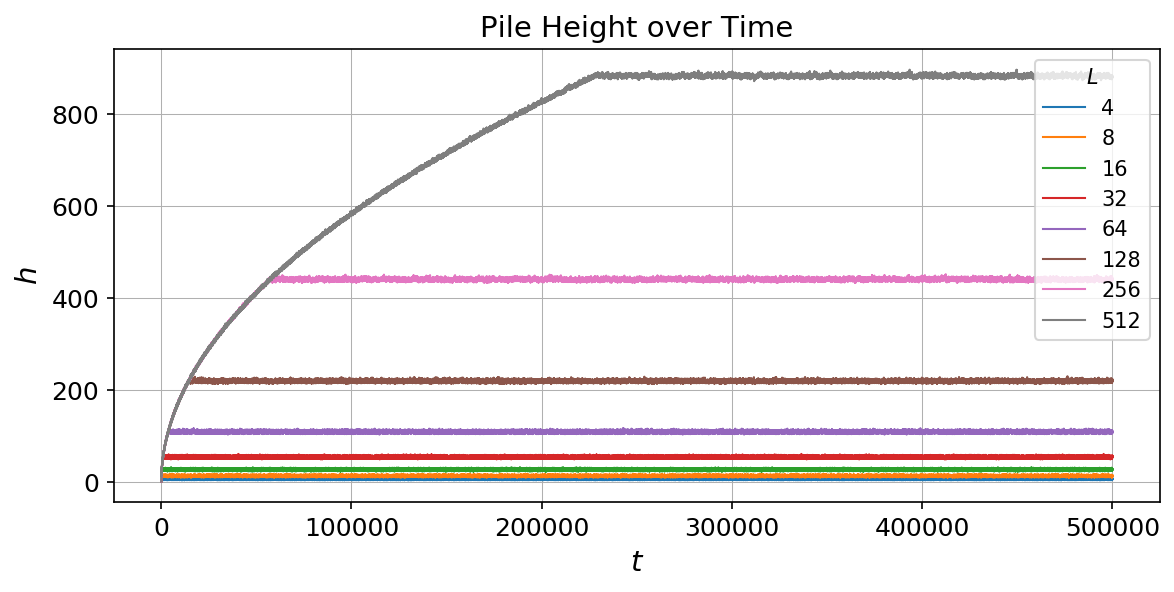

In [8]:
#height_cols = [str(l) + 'h' for l in L]
#df[height_cols].plot(lw=1, ms=0)
df_h[L].plot(lw=1, ms=0)
plt.grid()
plt.legend(L, loc=1, title='$L$')
plt.title('Pile Height over Time')
plt.xlabel('$t$')
plt.ylabel('$h$')
plt.show()

Transient configurations occur during the initial curve, and recurrent configurations are represented by the constant lines after the curve.

### Task 2b: Investigating $t_{c}(L)$

In [12]:
# Numerically measure cross-over time for each system size
tc = [measure_cross_over_time(l) for l in L]

2.0191260566966442 -0.24335757474784536


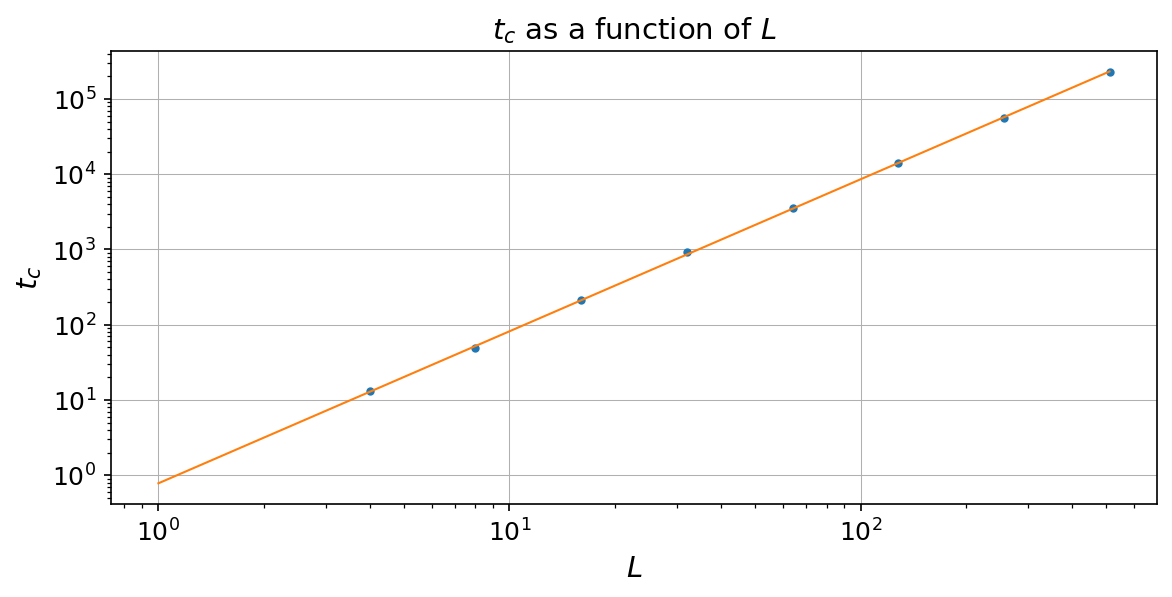

In [14]:
# Fit a linear regression
slope, intercept, r_value, p_value, std_err = linregress(np.log(L), np.log(tc))
print(slope, intercept)
# Plot the linear fit on the data points
x = np.power(2, np.arange(10))
plt.loglog(L, tc, ms=3, marker='o', lw=0)
plt.loglog(x, np.power(x, slope)*np.exp(intercept), ms=0, lw=1)
plt.grid()
plt.title('$t_{c}$ as a function of $L$')
plt.xlabel('$L$')
plt.ylabel('$t_{c}$')
plt.show()

Note that the slope is ~2 and intercept ~0, implying the relationship $\langle t_c(L) \rangle = L^2$.

### Task 2c: Scaling Behaviour

An apprximation of the pile for large L in the steady state is shown in the figure below. It resembles a triangle.

In the steady state, all sites will be filled to the threshold value. Since the threshold value is either 1 or 2, we can expect the average gradient to average out to a constant between 1 and 2 for large L. As such, $\langle h \rangle \propto L$. 

To arrive at the steady state, all the sites in the pile must be filled such that they equal the threshold value. Hence $t_c = area\, of\, pile = 0.5 \times L \times \langle h \rangle \propto L^2$.

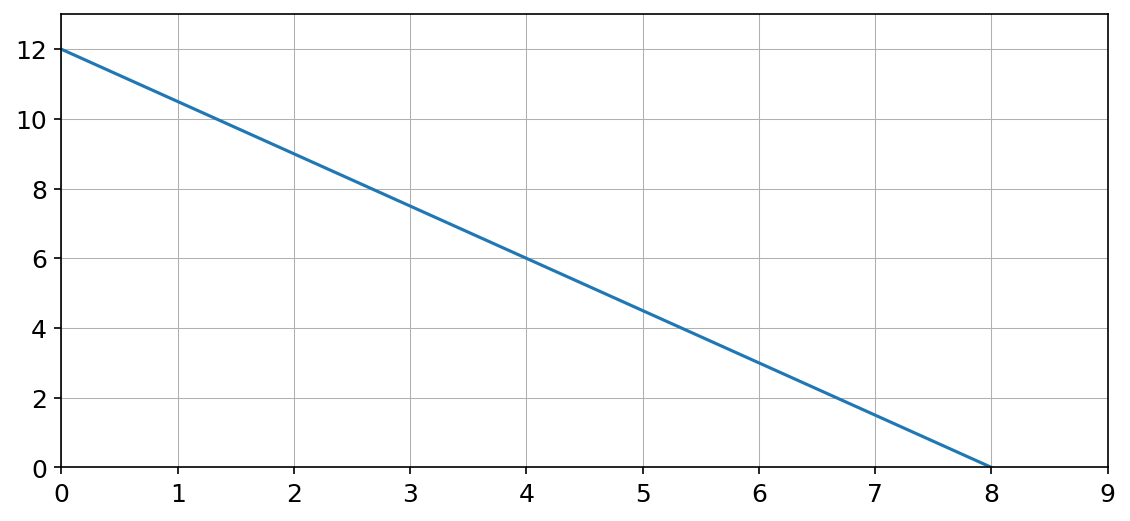

In [73]:
plt.plot(np.arange(9), -1.5*np.arange(9)+12)
plt.grid()
plt.xlim(0, 9)
plt.ylim(0, 13)
plt.show()

### Task 2d: Data Collapse

Assume that the height can be given $\tilde{h}(t;L) = L \, F(t/L^2)$ for some scaling function $F(x)$. We expect $F \propto L^{-1}$ when $x<<1$ so that $\widetilde{h}$ is constant at large $L$, and $F=constant$ when $x>>1$ so that $\widetilde{h} \propto L$ at small $L$. Plot $\tilde{h}/L$ against $t/L^2$ to observe data collapse.

In [134]:
# Smoothen data by averaging different simulations
data_h_tilde = []
for file in os.listdir('data'):
    data = np.load('data/' + file)
    data_h_tilde.append(data[:,:,0])
df_h_tilde = pd.DataFrame(np.mean(data_h_tilde, axis=0), columns=L, index=index)
df_h_tilde['t'] = df_h_tilde.index

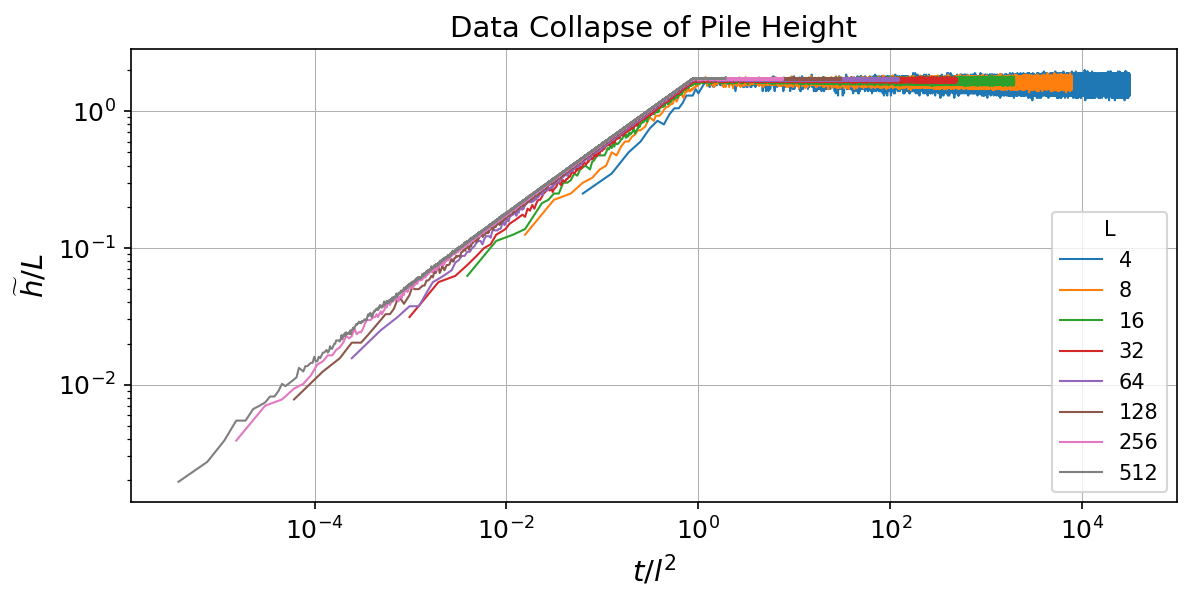

In [135]:
for l in L:
    df_rescaled = df_h_tilde[[l, 't']].divide([l, l**2])
    plt.loglog(df_rescaled['t'], df_rescaled[l], label=l, lw=1)
plt.legend(title='L', loc=4)
plt.xlabel('$t/l^2$')
plt.ylabel('$\widetilde{h}/L$')
plt.title('Data Collapse of Pile Height')
plt.grid()
plt.show()

### Task 2e: Scaling Corrections

For the scaling form $\langle h(t;L) \rangle _t = a_0 L (1-a_1 L^{-\omega_1})$, we can use curve fitting to obtain the vlaue of the constants  m. 

In [56]:
h_ave = [df_h[l][t:].mean() for l, t in zip(L, tc)]

# Scaling function to fit
def scaling(L, a0, a1, w1):
    L = np.array(L)
    return a0 * L * (1 - a1 * (L**(-w1)))

popt, pcov = curve_fit(scaling, L, h_ave)
pstd = np.sqrt([pcov[i,i] for i in range(pcov.shape[0])])
popt, pstd

(array([1.73438795, 0.227358  , 0.60189154]),
 array([0.00060571, 0.01364509, 0.01872796]))

Estimates for the constants are: $a_0 = 1.7343 \pm 0.0006$, $a_1 = 0.23 \pm 0.013$ and $\omega_1 = 0.60 \pm 0.02$. This gives $\langle h \rangle _t = 1.73 L (1- 0.23 L ^{0.60})$.

### 2f: Scaling of Standard Deviation

We suspect that $\sigma_h$ follows a power law, so fit the log using linear regression and plot.

0.23956629470971855 -0.5391689336741183


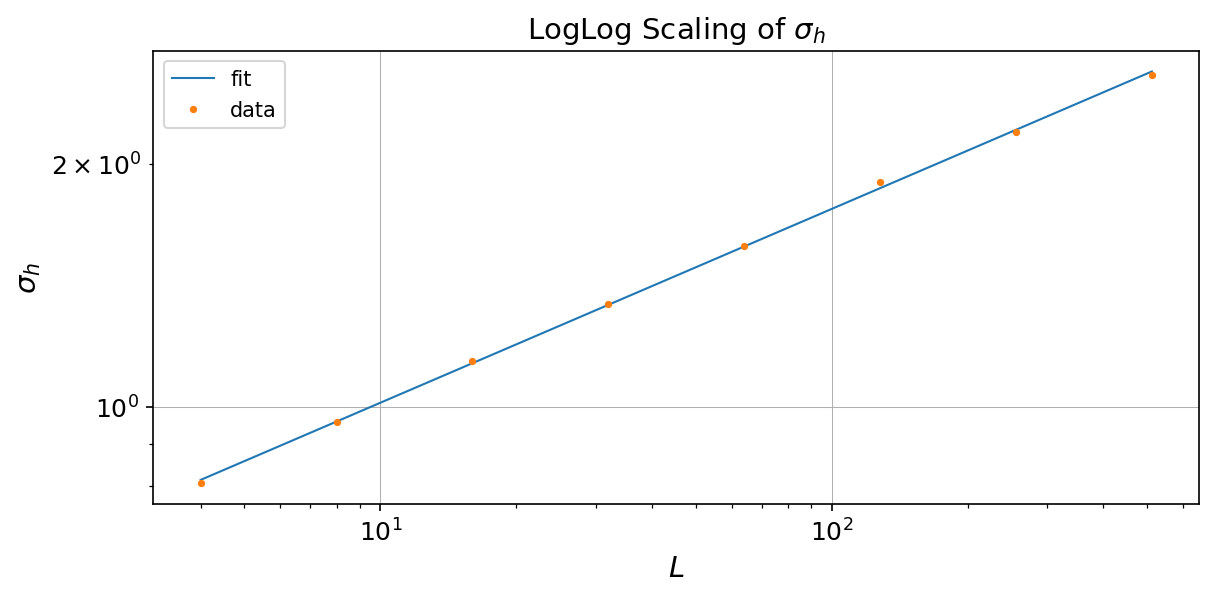

In [119]:
h_std = [df_h[l][t:].std(ddof=0) for l, t in zip(L, tc)]
# Linear fit of log-log
slope, intercept, r_value, p_value, std_err = linregress(np.log(L), np.log(h_std))
print(slope, intercept)
# Plot
plt.loglog(L, np.power(L,slope)*np.exp(intercept), lw=1, label='fit')
plt.loglog(L, h_std, lw=0, ms=2.5, marker='o', label='data')
plt.xlabel('$L$')
plt.ylabel('$\sigma_h$')
plt.title('LogLog Scaling of $\sigma_h$')
plt.grid()
plt.legend()
plt.show()

The standard deviation takes the form $\sigma_h = e^{-0.54} L^{0.24}$.

Average slope is given by $\langle h \rangle / L = 1.73 (1- 0.23 L ^{0.60})$. As $L \rightarrow \infty$, $\langle slope \rangle \propto L^{0.60}$ while $\sigma_h \propto L^{0.24}$. Slope increases faster than standard deviation, so the value of the slope becomes more stable.

### Task 2g: Height Porbability

By central limit theorem, $h$ should be normally distributed with the peak at $\langle h \rangle = \langle z_i \rangle$. Variance of the normal distribution will be $\sigma _h = \sigma _{z_{i}}/\sqrt{L}$. $P(h;L)$ will have the same distribution but rescaled by rescaling the value of $h$ with $\sum h$ for some $L$.

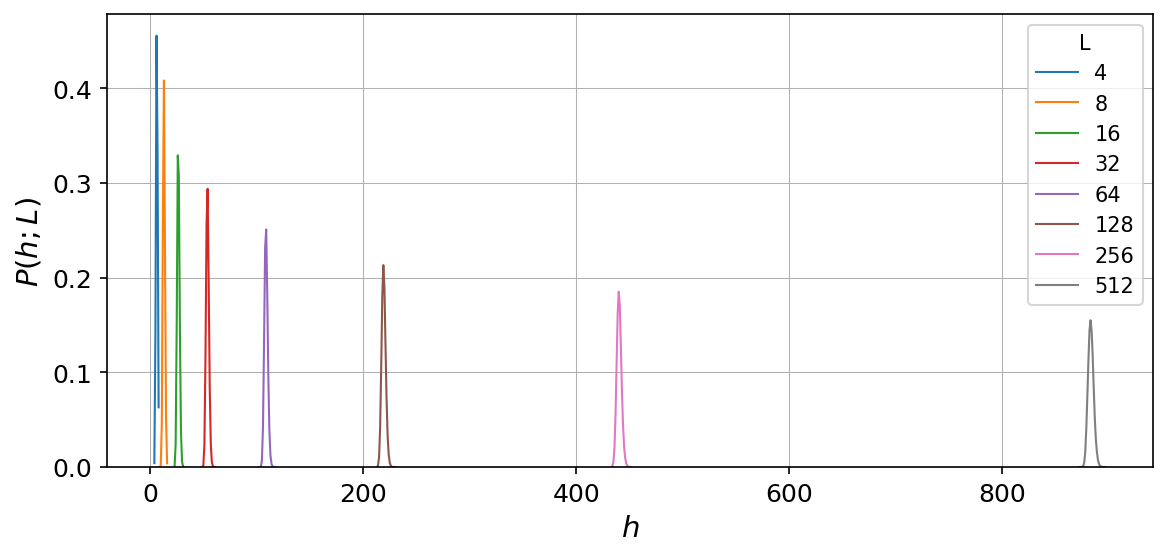

In [128]:
P_h = []
h = []
for l, t in zip(L, tc):
    counts = df_h[l][t:].value_counts(sort=False)
    h.append(list(counts.index))
    P_h.append(np.divide(list(counts),np.sum(list(counts))))
for i, l in enumerate(L):
    # Sort P and h so graph appears correctly
    plt.plot(h[i], P_h[i], label=l, lw=1)
plt.xlabel('$h$')
plt.ylabel('$P(h;L)$')
plt.grid()
plt.ylim(0)
plt.legend(title='L')
plt.show()

To achieve data collapse, we rescale each distribution by $\sigma_h$ and translate the mean by $\langle h \rangle$. All distributions will now resemble a standard normal distribution predicted theoretically.

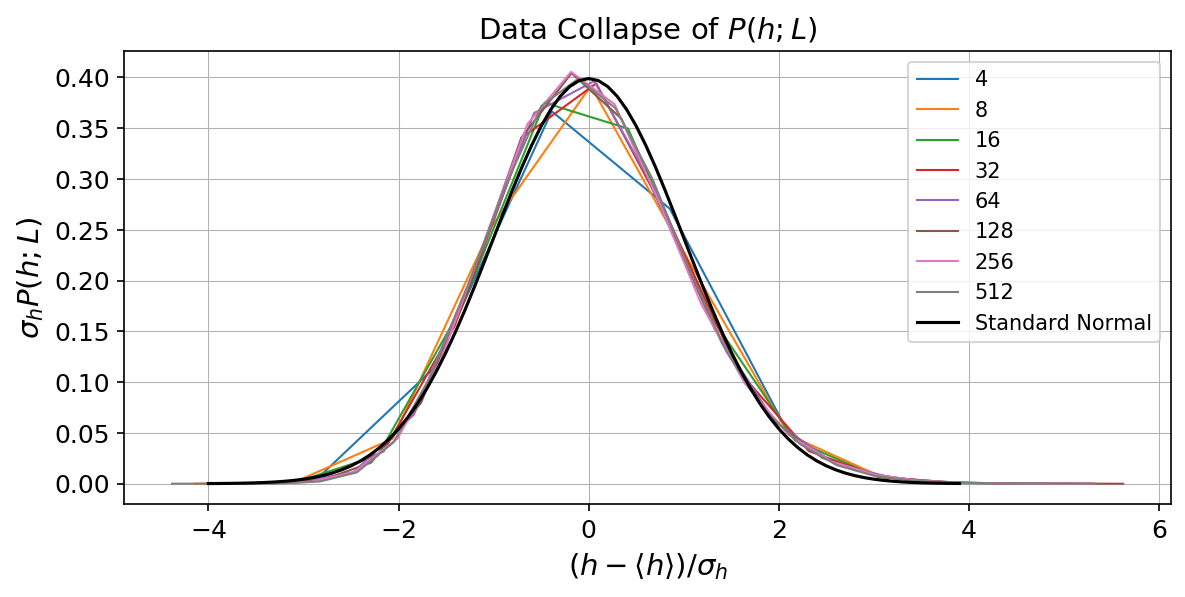

In [132]:
h_collapse = []
P_collapse = []
for i, l in enumerate(L):
    h_collapse.append(np.divide(np.subtract(h[i], h_ave[i]), h_std[i]))
    P_collapse.append(np.multiply(P_h[i], h_std[i]))
    
for i, l in enumerate(L):
    plt.plot(h_collapse[i], P_collapse[i], lw=1, label=l)

x = np.arange(-4, 4, 0.1)
plt.plot(x, norm.pdf(x, 0, 1), label='Standard Normal', color='black')
plt.grid()
plt.legend()
plt.xlabel(r'$(h - \langle h \rangle) / \sigma _{h}$')
plt.ylabel(r'$\sigma_{h}P(h;L)$')
plt.title('Data Collapse of $P(h;L)$')
plt.show()